# [LELEC2870] - Machine Learning

## Practical Session 5 - Deep Learning and Convolutional Neural Networks 

Prof. Michel Verleysen<br>
Prof. John Lee<br>

**Teaching assistants :**  
Edouard Couplet : edouard.couplet@uclouvain.be  <br>
Audrey Vermeulen: audrey.vermeulen@uclouvain.be<br>
Maxime Zanella: maxime.zanella@uclouvain.be<br>

### Imports

Before starting this practical session, make sure that all necessary libraries are installed on your computer. If you attended the last practical session, you should not have to install anything - in theory ;-)

In [3]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from PIL import Image  # "PIL" stands for the "pillow" library.  
# Pillow is a dependency of pytorch. Hence, if you installed pytorch correctly, you should not have anything else to install.

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from P5_utils import (visualize_sample_images, 
                      visualize_dataset_tSNE, 
                      visualize_2Dconvolution, 
                      verify_number_of_parameters, 
                      visualize_regression_results)

import warnings
# Ignore all warning messages
warnings.filterwarnings('ignore')

### Dataset

The dataset for this practical sessions is part of the dataset that you will use in the project. Indeed, we will use 48 by 48 pixel images of heart scans to predict the risk (i.e., the probability) of developping a heart failure within the next 10 years. We will also explore how to extract features from the images that can the be used together with other data types (i.e, the remaining part of the project dataset). As you may have guessed, if you already read the project guidelines, this dataset is entirely **synthetic**: it is about Smurfs! Here is what healthy Smurf hearts look like:

<img src="smurf_heart.png" width = "800">

To handle image data more easily, we will define a custom dataset class which inherits from pytorch's default <code>Dataset</code> class. This class contains three methods: 
- a constructor <code>init()</code> which stores image filenames, the path of the directory where images are located and target values if specified
- a <code>len()</code> method that simply returns the length of the dataset, which we define naturally as the number of sample images
- a <code>getitem()</code> method that allows to retrieve elements by their index using something like <code>image = dataset[idx]</code> where <code>dataset</code> is an instance of <code>CustomDataset</code> and <code>idx</code> is the given index value

<div class="alert alert-success">
<b>Code</b>  <br>
Read the code bellow and try to understand its main aspects. <br>
Run the cell.
</div>

In [4]:
# Define a custom dataset class that inherits from the PyTorch Dataset class
class CustomDataset(Dataset):
    
    # Constructor for the dataset
    def __init__(self, images, images_directory, target=None, transform=None):
        # Initialize the dataset with the provided data and transformation options
        self.images = images #List of image filenames
        self.images_directory = images_directory # Directory where images are located
        self.target = target # Optional list of target labels
        
        # If no data transformation is provided, create a default transformation
        if transform is None:
            transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
                                            transforms.ToTensor(), # Convert the image to a PyTorch tensor
                                            transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize the image data 
                                           ])
            
        self.transform = transform # Store the data transformation for later use

    # Define the length of the dataset (number of data samples)
    def __len__(self):
        return len(self.images)
    
    # Retrieve a specific data sample by its index
    def __getitem__(self, idx):
        # Construct the full path to the image file
        image_path = os.path.join(self.images_directory, self.images[idx])
        # Open the image using the PIL library
        image = Image.open(image_path)
        
        # Apply the data transformation if it exists
        if self.transform:
            image = self.transform(image)
        
        # If target labels are provided, return both the image and the corresponding label esle return only the image
        if self.target is not None:
            target = self.target[idx]
            return image, target
        else:
            return image

Great, now that we have a custom dataset class, we can easily load image samples!

<div class="alert alert-success">
<b>Code</b>  <br>
Run the cell bellow to display a grid of sample images. <br>
Can you already observe some patterns in the images that are associated with higher risks of heart failure?
</div>

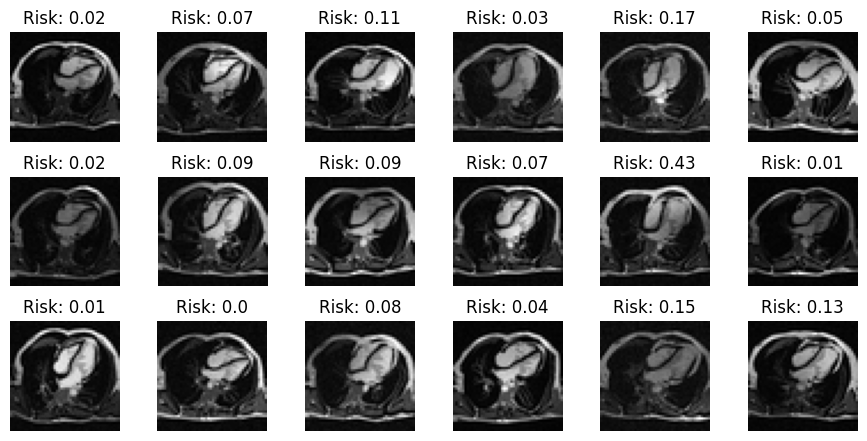

In [9]:
%matplotlib inline

# Retrieve image paths
images = pd.read_csv("data/X_train.csv")["img_filename"]

# Retrieve targets/labels
risk = pd.read_csv("data/y_train.csv", header=None, names=['risk'])

# Create image dataset
dataset = CustomDataset(images, "data/Img_train", target=risk.values)

# Display of grid of sample images from the dataset
visualize_sample_images(dataset, gridsize=(3,6))

Oberving patterns would perhaps be easier if we could view all images at the same time, in a condensed representation. This can be achieved using dimensionality reduction algorithms such as t-SNE (student-t stochastic neighbor embedding). We will not explain in details how t-SNE works as this will be covered later in the course. Just know that it takes as input flattened versions of images (pixel values arranged in a vector of 48x48=2304 dimensions) and ouputs 2-dimensional vectors that can be represented as points in a plane. The main idea is that if two images are similar, the two corresponding points will also be close to one another in the plane. 

<div class="alert alert-success">
<b>Code</b>  <br>
Run the cell bellow to represent all images as points in the plane (it may take a bit of time). Hover over the points with your mouse to observe corresponding images. Points are colored according to the associated risk of heart failure.<br>
Can you observe some patterns now ?
</div>

Dataset 2D visualization --- t-SNE on pixel values


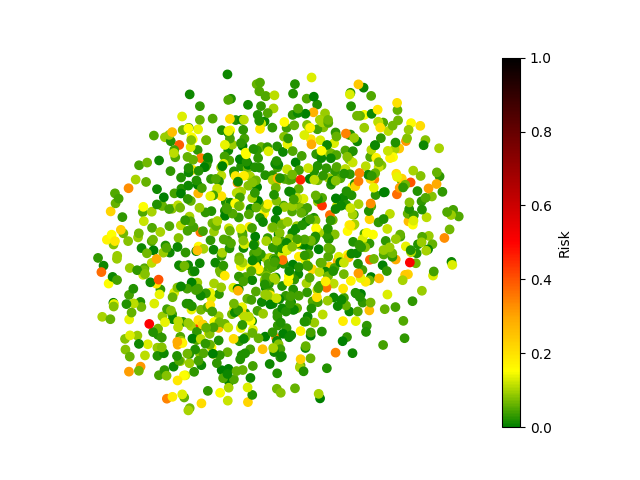

In [10]:
%matplotlib widget

print("Dataset 2D visualization --- t-SNE on pixel values")
visualize_dataset_tSNE(dataset)

### The 2D convolution

Convolution is a ubiquituous operation in computer science and in all sciences in general. Its math is fascinating and if you have time to dive into it, you definitely should. In this practical session, we will only focus on a more "graphical" representation: convolving an image with a given kernel is essentially taking successive dot  products between the kernel and sliding portions of the image.

<img src="convolution_kernel.png" width = "400">

Here is a small animation that illustrates these "sliding dot products" on a 5x5 input with a 3x3 kernel (from https://arxiv.org/pdf/1603.07285).

<img src="convolution.gif" width = "400">

<div class="alert alert-success">
<b>Code</b>  <br>
To build a stronger intuition of what convolution does, look at the three kernels defined bellow. Before running the cell, try to predict the effect they will have when convolved with a given image.<br>
Now run the cell, are the results what you expected ? <br>
Do not hesitate to play around with other custom kernels.
    

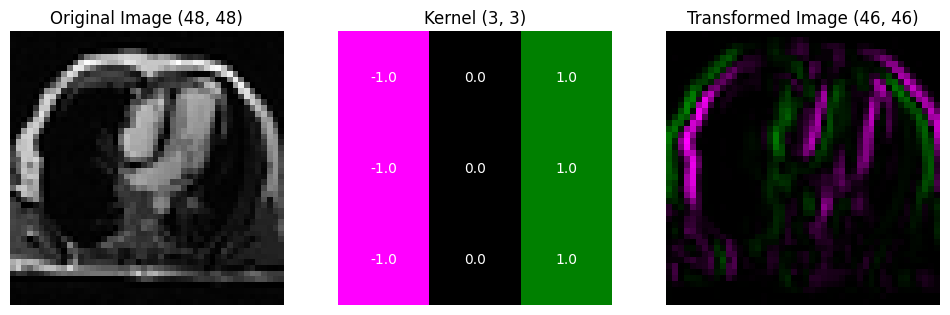

In [ ]:
%matplotlib inline

# choose one image in the dataset
idx = 20
image, _ = dataset[idx]

# Define custom kernels 
# effect of kernel_1?
kernel_1 = np.array([[1/16, 1/8, 1/16],
                     [1/8, 1/4, 1/8],
                     [1/16, 1/8, 1/16]])
# effect of kernel_2?
kernel_2 = np.array([[-1/8, 0, 1/8],
                     [-1/4, 0, 1/4],
                     [-1/8, 0, 1/8]])
# effect of kernel_3?
kernel_3 = kernel_2.T

kernel_4 = np.array([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]])

# Convolve image with kernel and display the result (Note that colors are used only for the purpose of visualization)
visualize_2Dconvolution(image, kernel_4) # EXPERIMENT HERE WITH DIFFERENT KERNELS




Kernels can be seen as feature detectors. Hence, in deep learning, the output of the convolution between an image and a kernel is commonly called a **feature map**. The whole point of a convolutional neural network (CNN) is to bypass hand crafted kernels/feature detectors and to learn those kernels automatically, based on data. **CNN themselves can be seen as big automatic feature extractors**.

### A convolutional neural network (CNN)

There exists a huge variety of CNN arcitectures. For the project and for this practical session, we provide you with a very simple architecture defined in the pytorch class <code>SimpleCNN</code>.

<div class="alert alert-success">
<b>Code</b>  <br>
Read every line of code carefully. Try to write the sizes of the tensors at each step (do not worry about the batch size for now). Refer to this <a href="https://poloclub.github.io/cnn-explainer/">awesome interactive tutorial on CNNs</a> for help - or to your teaching assistants of course;-). Also note that we are solving a regression task and not a classification task. Finally, run the cell. <br>
</div>

In [20]:
# Define a custom CNN class (in this class, we define the network architecture)  
class SimpleCNN(nn.Module):
    
    # Constructor for the CNN 
    def __init__(self, n_features):
        super(SimpleCNN, self).__init__()
        
        # Define the layers of the CNN
        # First convolutional layer with 1 input channel, 8 output channels, 3x3 kernel, and padding
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        # First max-pooling layer with 2x2 kernel
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Second convolutional layer with 8 input channels, 8 output channels, 3x3 kernel, and padding
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1)
        # Second max-pooling layer with 2x2 kernel
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Fully connected layer with input size 8*7*7 and output size n_features
        self.fc1 = nn.Linear(8*12*12, n_features)
        # Fully connected layer with input size n_features and output size 1
        self.fc2 = nn.Linear(n_features, 1) 
    
    # Define the forward pass of the model
    def forward(self, x):
        # Apply the two first convolutional layers with max-pooling and ReLU activation functions
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        # Reshape the data for the fully connected layers
        x = x.view(-1, 8*12*12)
        # Pass the data through the first fully connected layer (and extract features)
        extracted_features = self.fc1(x)
        # Pass the extracted features through the second fully connected layer to get the final output
        out = self.fc2(extracted_features)
        # return output and extracted features
        return out, extracted_features


<div class="alert alert-warning">
<b>Question</b>  <br>
- How many trainable parameters are there in this network? Run the cell bellow to verify your guesses. This question was already asked at an exam so you should really try to answer it by hand ;-)
</div>

In [42]:
model = SimpleCNN(n_features=8)
my_guess = 9897 # Provide your guess 

verify_number_of_parameters(my_guess, model)

You are correct! There is indeed 9897 parameters in this neural network.


<div class="alert alert-warning">
<b>Other questions you should really try to answer </b>  <br>
- What is the size of an output feature map given the input map size, the kernel size (assume a square kernel), the stride, and the padding ? <br>
- What is the receptive field of the second max pooling kernel (self.pool2) ? <br>
- Can you define "Kernel"? "Filter"? "Channel" ? Can you complete the following sentences : "There are as many kernels in a ... as there are ...", "There is as many output channels as ..."? (Note that there is no consensus on the nomenclature so do not obsess on this one)
</div>



### Training a CNN

Time to put everything together. Now that we have a network architecture, we can define a proper CNN model in the <code> MyCNN </code> class. This class contains three main methods:
- a constructor <code>init()</code> which stores hyper-parameter values.
- a <code>fit()</code> method that contains the training loop and hence that allows to train the neural network (i.e., fit its weights to the training data).
- a <code>predict()</code> methods that uses the trained network to make predictions on the provided data. <br>

These three methods are the base of most neural networks implemented in pytorch. Additionally, we define:
- the <code>extract features()</code> method to retrieve the output of the first linear fully conncected layer (or input of the last linear layer). The dimension of this feature vector is an hyper-parameter specified by the user (default=8).

<div class="alert alert-success">
<b>Code</b>  <br>
Read and understand the code bellow. If you are short on time, focus on the <code>fit()</code> method. <br>
Finally, run the cell.
</div>


In [46]:
# Define a custom CNN model class (in this class, we define how to train the model)
class MyCNN(object):
    
    # Constructor for the custom CNN model
    def __init__(self, n_features=8, n_epochs=25, batch_size=20, learning_rate=0.0005):
        self.n_features = n_features
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
    
    # Method to train the custom CNN model
    def fit(self, images, y, data_dir):
        
        # Train and validation data split
        split_ratio = 0.75
        split_index = int(len(images) * split_ratio)
        images_train = images[:split_index]
        y_train = y[:split_index]
        images_val= images[split_index:]
        y_val = y[split_index:]

        # Datasets
        train_dataset = CustomDataset(images_train, data_dir, y_train)
        val_dataset = CustomDataset(images_val, data_dir, y_val)

        # Data loaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        # Create an instance of the SimpleCNN model
        self.model = SimpleCNN(n_features=self.n_features)

        # Define loss function and optimizer
        criterion = nn.MSELoss(reduction='mean')
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Training loop
        for epoch in range(self.n_epochs):

            # Set the model in training mode
            self.model.train()
            # Initialize running loss
            running_loss = 0
            # Iterate over batches of training data
            for i, data in enumerate(train_loader):
                inputs, labels = data
                
                # Forward pass: Calculate model predictions and compute the loss
                outputs, _ = self.model(inputs)
                loss = criterion(outputs.squeeze(),labels.float())
                
                # Backpropagation: Zero the gradients, calculate gradients, and update the model's parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Keep track of the running loss for this epoch
                with torch.no_grad():
                    running_loss += loss.item()
            
            # Calculate the average training loss for this epoch
            train_loss = np.sqrt(running_loss/(i+1))

            # Model evaluation on the validation set
            # Set the model in evaluation mode
            self.model.eval()
            # Initialize running loss
            running_loss = 0
            # Iterate over batches of validation data
            for i, data in enumerate(val_loader):
                inputs, labels = data
                
                # Forward pass: Calculate model predictions (no gradient calculation)
                with torch.no_grad():
                    outputs, _ = self.model(inputs)
                    loss = criterion(outputs.squeeze(), labels.float())
                    running_loss += loss.item()
            
            # Calculate the average validation loss for this epoch
            val_loss = np.sqrt(running_loss/(i+1))
            
            # Print the training and validation loss every 5 epochs
            print("Epoch: {epoch:2d} | Train loss: {train:5.3f} | Val loss: {val:5.3f}".format(epoch=epoch+1,
                                                                                                   train=train_loss,
                                                                                                   val=val_loss))
    # Method to make predictions with trained SimpleCNN model            
    def predict(self, images, data_dir):
        
        # Create a dataset from the input images and data directory
        dataset = CustomDataset(images, data_dir)
        # Create a data loader with a batch size equal to the number of input images
        loader = DataLoader(dataset, batch_size=len(images), shuffle=False)
        
        # Initialize an array to store predicted values
        y_pred = np.zeros(len(images))
        
        # Set the model to evaluation mode (to disable features like dropout if needed)
        self.model.eval()
        # Make predictions on the input images without gradient calculation
        with torch.no_grad():
            for inputs in loader:
                y_pred, _ = self.model(inputs)
        
        # Convert the predictions to a NumPy array and reshape it
        return y_pred.numpy().reshape(-1)
    
    
    # Method to extract features from input images with trained SimpleCNN model  
    def extract_features(self, images, data_dir):
        
        # Create a dataset from the input images and data directory
        dataset = CustomDataset(images, data_dir)
        # Create a data loader with a batch size equal to the number of input images
        loader = DataLoader(dataset, batch_size=len(images), shuffle=False)
        
        # Set the model to evaluation mode (to disable features like dropout)
        self.model.eval()
        # Extract features from the input images without gradient calculation
        with torch.no_grad():
            for inputs in loader:
                _, features = self.model(inputs)
        
        # Convert the extracted features to a NumPy array
        return features.numpy()
    

<div class="alert alert-success">
<b>Code</b>  <br>
Run the code bellow. We perform a train/test split and fit the model to the training data. We then evaluate the model on the test data and display some basic residual/error analysis. What can you observe ?
</div>

Epoch:  1 | Train loss: 0.088 | Val loss: 0.084
Epoch:  2 | Train loss: 0.084 | Val loss: 0.082
Epoch:  3 | Train loss: 0.083 | Val loss: 0.081
Epoch:  4 | Train loss: 0.082 | Val loss: 0.080
Epoch:  5 | Train loss: 0.081 | Val loss: 0.079
Epoch:  6 | Train loss: 0.079 | Val loss: 0.077
Epoch:  7 | Train loss: 0.077 | Val loss: 0.076
Epoch:  8 | Train loss: 0.074 | Val loss: 0.074
Epoch:  9 | Train loss: 0.071 | Val loss: 0.073
Epoch: 10 | Train loss: 0.068 | Val loss: 0.072
Epoch: 11 | Train loss: 0.067 | Val loss: 0.070
Epoch: 12 | Train loss: 0.063 | Val loss: 0.070
Epoch: 13 | Train loss: 0.062 | Val loss: 0.070
Epoch: 14 | Train loss: 0.060 | Val loss: 0.069
Epoch: 15 | Train loss: 0.058 | Val loss: 0.071
Epoch: 16 | Train loss: 0.058 | Val loss: 0.069
Epoch: 17 | Train loss: 0.056 | Val loss: 0.071
Epoch: 18 | Train loss: 0.055 | Val loss: 0.069
Epoch: 19 | Train loss: 0.055 | Val loss: 0.069
Epoch: 20 | Train loss: 0.053 | Val loss: 0.071
----------------------------------------

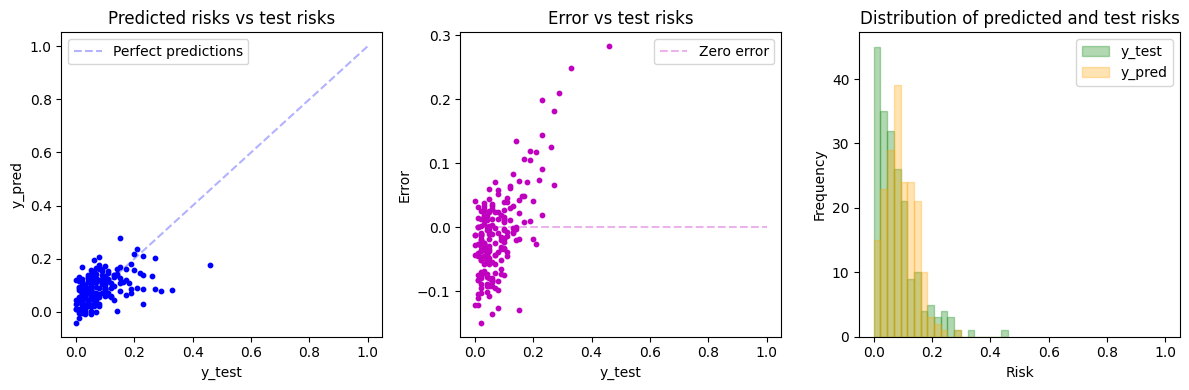

In [47]:
%matplotlib inline

# Load data and retrieve paths to images
images1 = pd.read_csv("data/X_train.csv")["img_filename"]

# Load targets
Y1 = pd.read_csv("data/y_train.csv", header=None, names=['risk'])

# Concatenate for easier train/test separation
df = pd.concat([images1,Y1], axis=1)

# Train/test split 
df_train = df.sample(frac=0.8)
df_test = df.drop(df_train.index)
images_train = df_train["img_filename"].values
y_train = df_train["risk"].values
images_test = df_test["img_filename"].values
y_test = df_test["risk"].values

# Define the number of features to extract 
n_features=8
# Create instance of cnn model
cnn = MyCNN(n_features=n_features, batch_size=50, n_epochs=20, learning_rate=0.0005) 

# Fit cnn
cnn.fit(images_train, y_train, 'data/Img_train')

# Performance evaluation
y_pred = cnn.predict(images_test, 'data/Img_train')
rmse_cnn = np.sqrt(np.mean((y_pred-y_test)**2))
print("-----------------------------------------------")
print("RMSE on test set - MyCNN : {rmse:5.3f}".format(rmse=rmse_cnn))
print("-----------------------------------------------")
visualize_regression_results(y_test,y_pred)

### Feature extraction

<div class="alert alert-success">
<b>Code</b>  <br>
Finally, we extract 8-dimensional features from the last layer of the network and use t-SNE to project them in the 2D plane. We compare this to a t-SNE embedding of the pixel values. As before, you can hover over the points with your mouse to display corresponding images. What do you observe ?
</div>



Dataset 2D visualization --- t-SNE on pixel values


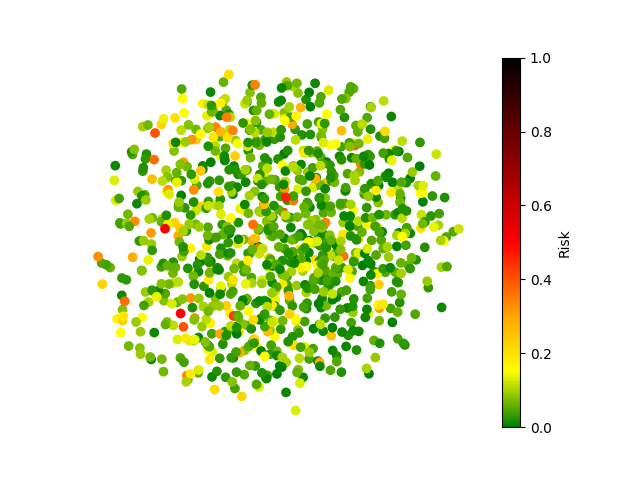

Dataset 2D visualization --- t-SNE on extracted features


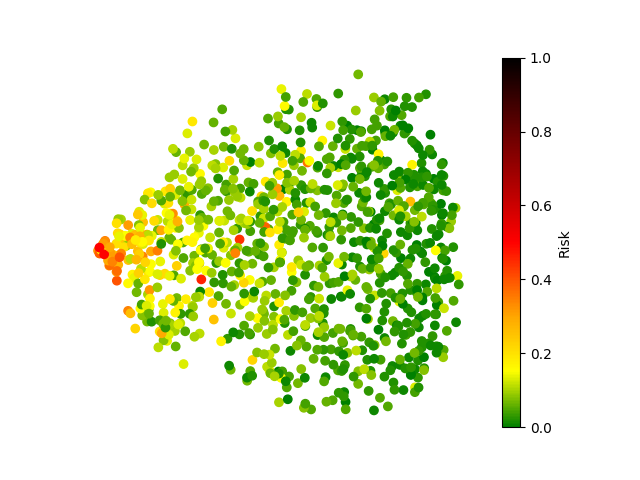

In [45]:
%matplotlib widget

print("Dataset 2D visualization --- t-SNE on pixel values")
visualize_dataset_tSNE(dataset)
print("Dataset 2D visualization --- t-SNE on extracted features")
visualize_dataset_tSNE(dataset, extract_features=True, feature_extractor=cnn)


### Bonus: self-supervised learning

Since the beginning of the session, we try to predict the risk of heart failure based on heart scans. We are thus working in a **supervised** setting: we know the targets and use them to make predictions and extract features. Note that we could also have done similar things in an **unsupervised** setting, or rather **self-supervised** setting. Indeed we can define a fake target and a proxy task, and extract feature that can potentially enhance the real task (e.g., we can rotate each image by some degree and  define a proxy task that consists in predicting the degree of this rotation). 